In [1]:
from pathlib import Path
from environment_manager import *
import re
import System
import Grasshopper.Kernel as ghk
from Grasshopper.Kernel import IGH_Component, IGH_Param, GH_Document
from Grasshopper.Kernel import GH_DocumentIO

In [2]:
# create the loggers


Create the version Environment

In [3]:

name = "240308-initial_test"
env = load_create_environment(name)
gct = GHComponentTable
GHComponentTable.initialise()



Setting environment variables
Copying vanilla components
File copied successfully from C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\Grasshopper Components\240307-CoreComponents\vanilla_components.csv to ExtractionEnvironments\240308-initial_test\00-VanillaComponents\vanilla_components.csv.
Copying components
Copying gh files


In [8]:


# Usage
file = Path(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\unzips_gh")
error_bin = r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\Error_Bin"
illegals_dict = {
        "Bifocals": "aced9701-8be9-4860-bc37-7e22622afff4",
        "Group": "c552a431-af5b-46a9-a8a4-0fcbc27ef596",
        "Sketch": "2844fec5-142d-4381-bd5d-4cbcef6d6fed",
        "Cluster": "f31d8d7a-7536-4ac8-9c96-fde6ecda4d0a",
        "Scribble": "7f5c6c55-f846-4a08-9c9a-cfdc285cc6fe"
    }

processor = GHDocumentPreprocessor(file, error_bin)
docs = processor.process_folder_or_file(illegals_dict)

Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Replacement of obsolete components co

Test Component Conversion

In [5]:
def test_component(file):
    doc = GHProcessor.get_ghdoc(str(file))
    for i, component in enumerate(doc.Objects):
        print(f'Loading... {i+1}/{len(list(doc.Objects))}', end='\r')
        a = GHComponent(component)
        if a is None:
            print(component)
    print(f"Processed {len(doc.Objects)} components in {file.name}")
    
test_component(Path(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\unzips_gh\Al Ibrahimi Tower_Advanced.gh"))


Processed 135 components in Al Ibrahimi Tower_Advanced.gh


# Test Single

In [6]:
import shutil
from pathlib import Path

run_preprocessing = True
error_bin = Path(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\Error_Bin")

def preprocess_single(file: Path, overwrite=True) -> GH_Document:
    illegals_dict = {
        "Bifocals": "aced9701-8be9-4860-bc37-7e22622afff4",
        "Group": "c552a431-af5b-46a9-a8a4-0fcbc27ef596",
        "Sketch": "2844fec5-142d-4381-bd5d-4cbcef6d6fed",
        "Cluster": "f31d8d7a-7536-4ac8-9c96-fde6ecda4d0a",
        "Scribble": "7f5c6c55-f846-4a08-9c9a-cfdc285cc6fe"
    }


    doc = GHProcessor.get_ghdoc(str(file))
    try:
        doc = preprocess_and_replace(doc, illegals_dict, overwrite)
        return doc
    except Exception as e:
        print(f"Error in preprocessing {file.name}: {e}")

        # a = GH_DocumentIO(doc).SaveQuiet(str(error_bin / file.name))
        # print(a)
    
# 
# file = Path(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\Test_many\265ee37e22db.gh")
# preprocess_single(file, True)
        

# Test Many

## Test preprocessing

In [7]:
run_preprocessing = True
def preprocess(folder: Path,  overwrite=True) -> GH_Document:
    assert isinstance(folder, Path), "The folder must be a Path object"
    illegals_dict = {
    "Bifocals": "aced9701-8be9-4860-bc37-7e22622afff4",
    "Group": "c552a431-af5b-46a9-a8a4-0fcbc27ef596",
    "Sketch": "2844fec5-142d-4381-bd5d-4cbcef6d6fed",
    "Cluster": "f31d8d7a-7536-4ac8-9c96-fde6ecda4d0a",
    "Scribble": "7f5c6c55-f846-4a08-9c9a-cfdc285cc6fe"
    }   
    for i, file in enumerate(folder.iterdir()):
        if file.suffix == ".gh":
            print(f"Preprocessing {file.name}...")
            doc = GHProcessor.get_ghdoc(str(file))
            doc = preprocess_and_replace(doc, illegals_dict, overwrite)
            print(f"Preprocessing of {file.name} complete.")
    print("finished processing all files")

folder = Path(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\unzips_gh")
print(type(folder))
if run_preprocessing:
    preprocess(folder)


<class 'pathlib.WindowsPath'>
Preprocessing 79B park update 1.gh...


NameError: name 'preprocess_and_replace' is not defined

## Test Node Conversion

In [ ]:
def process_item(item):
    if isinstance(item, Path) and item.is_dir():
        for file in item.iterdir():
            if file.suffix == ".gh":
                process_file(file)
    elif isinstance(item, Path) and item.is_file():
        if item.suffix == ".gh":
            process_file(item)
    else:
        print(f"Invalid item: {item}. Please provide a valid .gh file or a directory containing .gh files.")

def process_file(file):
    print(f"Processing {file.name}...")
    doc = GHProcessor.get_ghdoc(str(file))
    for i, component in enumerate(doc.Objects):
        print(f'Loading... {i+1}/{len(list(doc.Objects))}', end='\r')
        try:
            a = GHComponent(component)
            return a
        except TypeError:
            print(f"Component {component}: doesnt convert, removing from doc")
            doc.RemoveObject(component, True)
    GH_DocumentIO(doc).Save()

    print(f"Processed {len(doc.Objects)} components in {file.name}")

# usage
trun = True
if trun:
    item = Path(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\unzips_gh\Al Ibrahimi Tower_Advanced.gh")  # replace with your file or folder path
    process_item(item)
    print("Finished processing all files.")

#  Component Conversions

In [ ]:
def test_component_connections(file):
    doc = GHProcessor.get_ghdoc(str(file))
    canvas = Canvas("canvas", doc, env)
    complog.debug(f"Starting test on {file}")
    for i, component in enumerate(doc.Objects):
        a = GHComponent(component)
        print(a)
        complog.debug(f"Connections Node {a.name}: {a.get_connections(canvas)}")


        
file = r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\unzips_gh\Al Ibrahimi Tower_Advanced.gh"
test_component_connections(file)


In [ ]:
        plt.figure(figsize=(20, 12))  # Increase the figure size
        gx = self.nxGraph()

        # Generate category color map and assign colors
        category_color_map = self.generate_category_color_map()
        # Adjusted line for node_colors with a safety check for missing categories
        # First, ensure every node has a default color
        default_color = "grey"  # or any other color as fallback
        node_colors = [default_color for _ in range(len(gx.nodes))]  # Pre-fill with default color

        # Now, iterate over the nodes and set colors where applicable
        for i, graph_id in enumerate(gx.nodes):
            component = self.canvas.graph_id_to_component.get(graph_id)
            if component is not None:
                # If there's a specific category color, use it
                category = component.category
                node_colors[i] = category_color_map.get(category, default_color)
            # If the component is None, node_colors[i] remains the default color

        # Initialize default labels for all nodes
        default_label = "Unknown"  # Default label for nodes without specific data
        custom_labels = {node: default_label for node in gx.nodes}  # Pre-fill with default labels

        # Now, iterate over the nodes and set specific labels where applicable
        for node in gx.nodes:
            component = self.canvas.graph_id_to_component.get(node)
            if component is not None:
                # Update the label with specific data if available
                custom_labels[node] = component.name  # Assuming each component has a 'name' attribute
            # If the component is None, custom_labels[node] remains the default label

        # Choose a different layout to spread out nodes more
        pos = {node.graph_id: node.pos for node in self.nodes}  # Use your custom positions

        # Draw the graph with node colors and custom labels
        nx.draw(gx, pos, with_labels=True, labels=custom_labels, node_color=node_colors, node_size=1000,
                edge_color="gray", linewidths=0.5, font_size=10)

        # Create a legend for the categories
        legend_handles = [Patch(color=color, label=category) for category, color in category_color_map.items()]
        plt.legend(handles=legend_handles, title='Categories', bbox_to_anchor=(1, 1), loc='upper left')


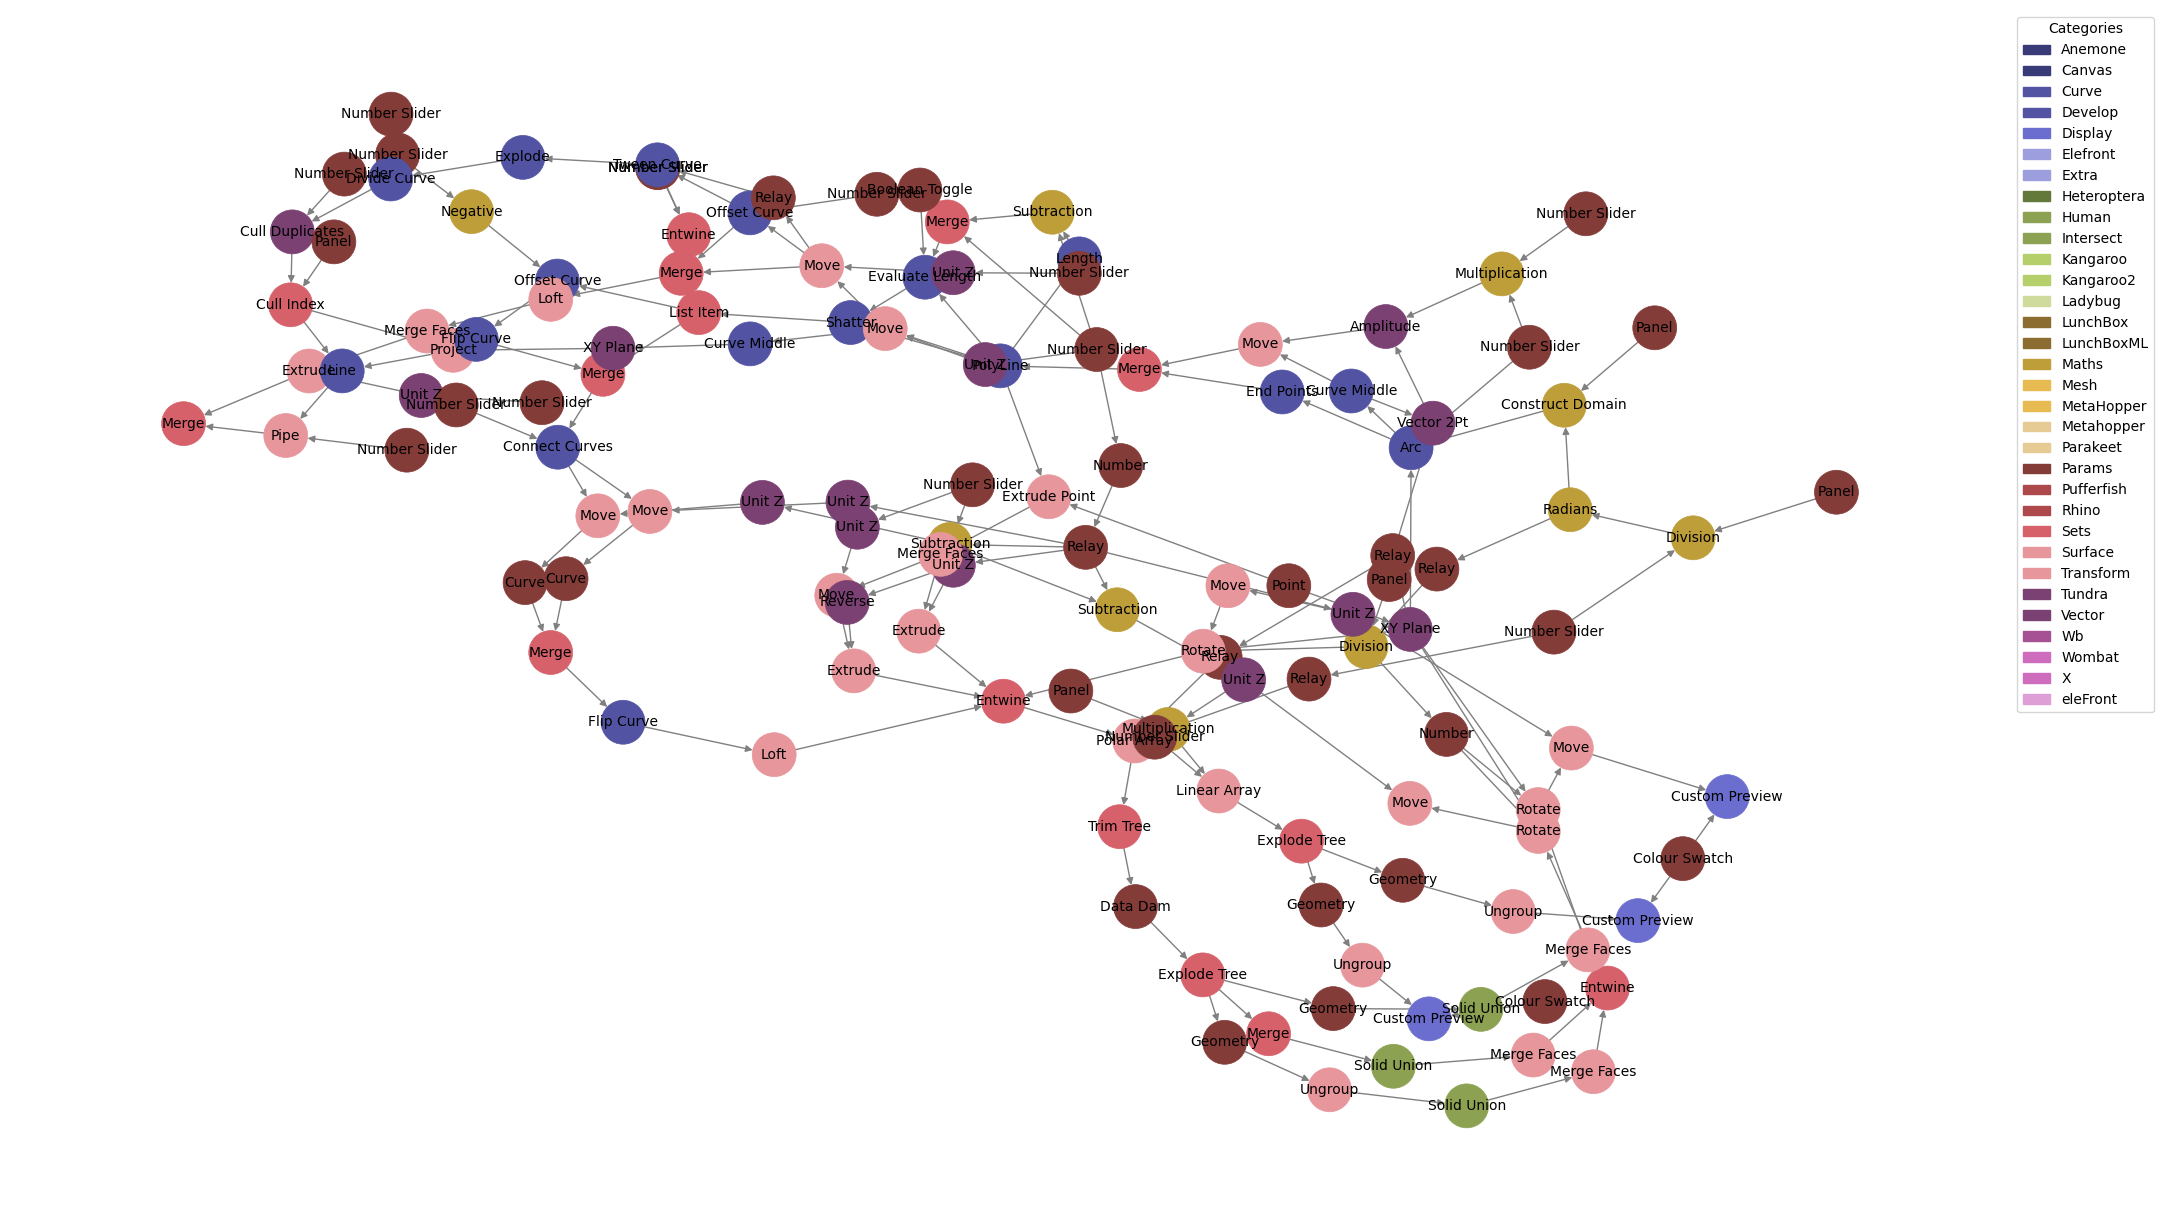

In [9]:
file = r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\unzips_gh\Al Ibrahimi Tower_Advanced.gh"
doc = GHProcessor.get_ghdoc(str(file))
canvas = Canvas("canvas", doc, env)

gh_graph = GHGraph(canvas)
gh_graph.show_graph()



Processing file: 79B park update 1.gh


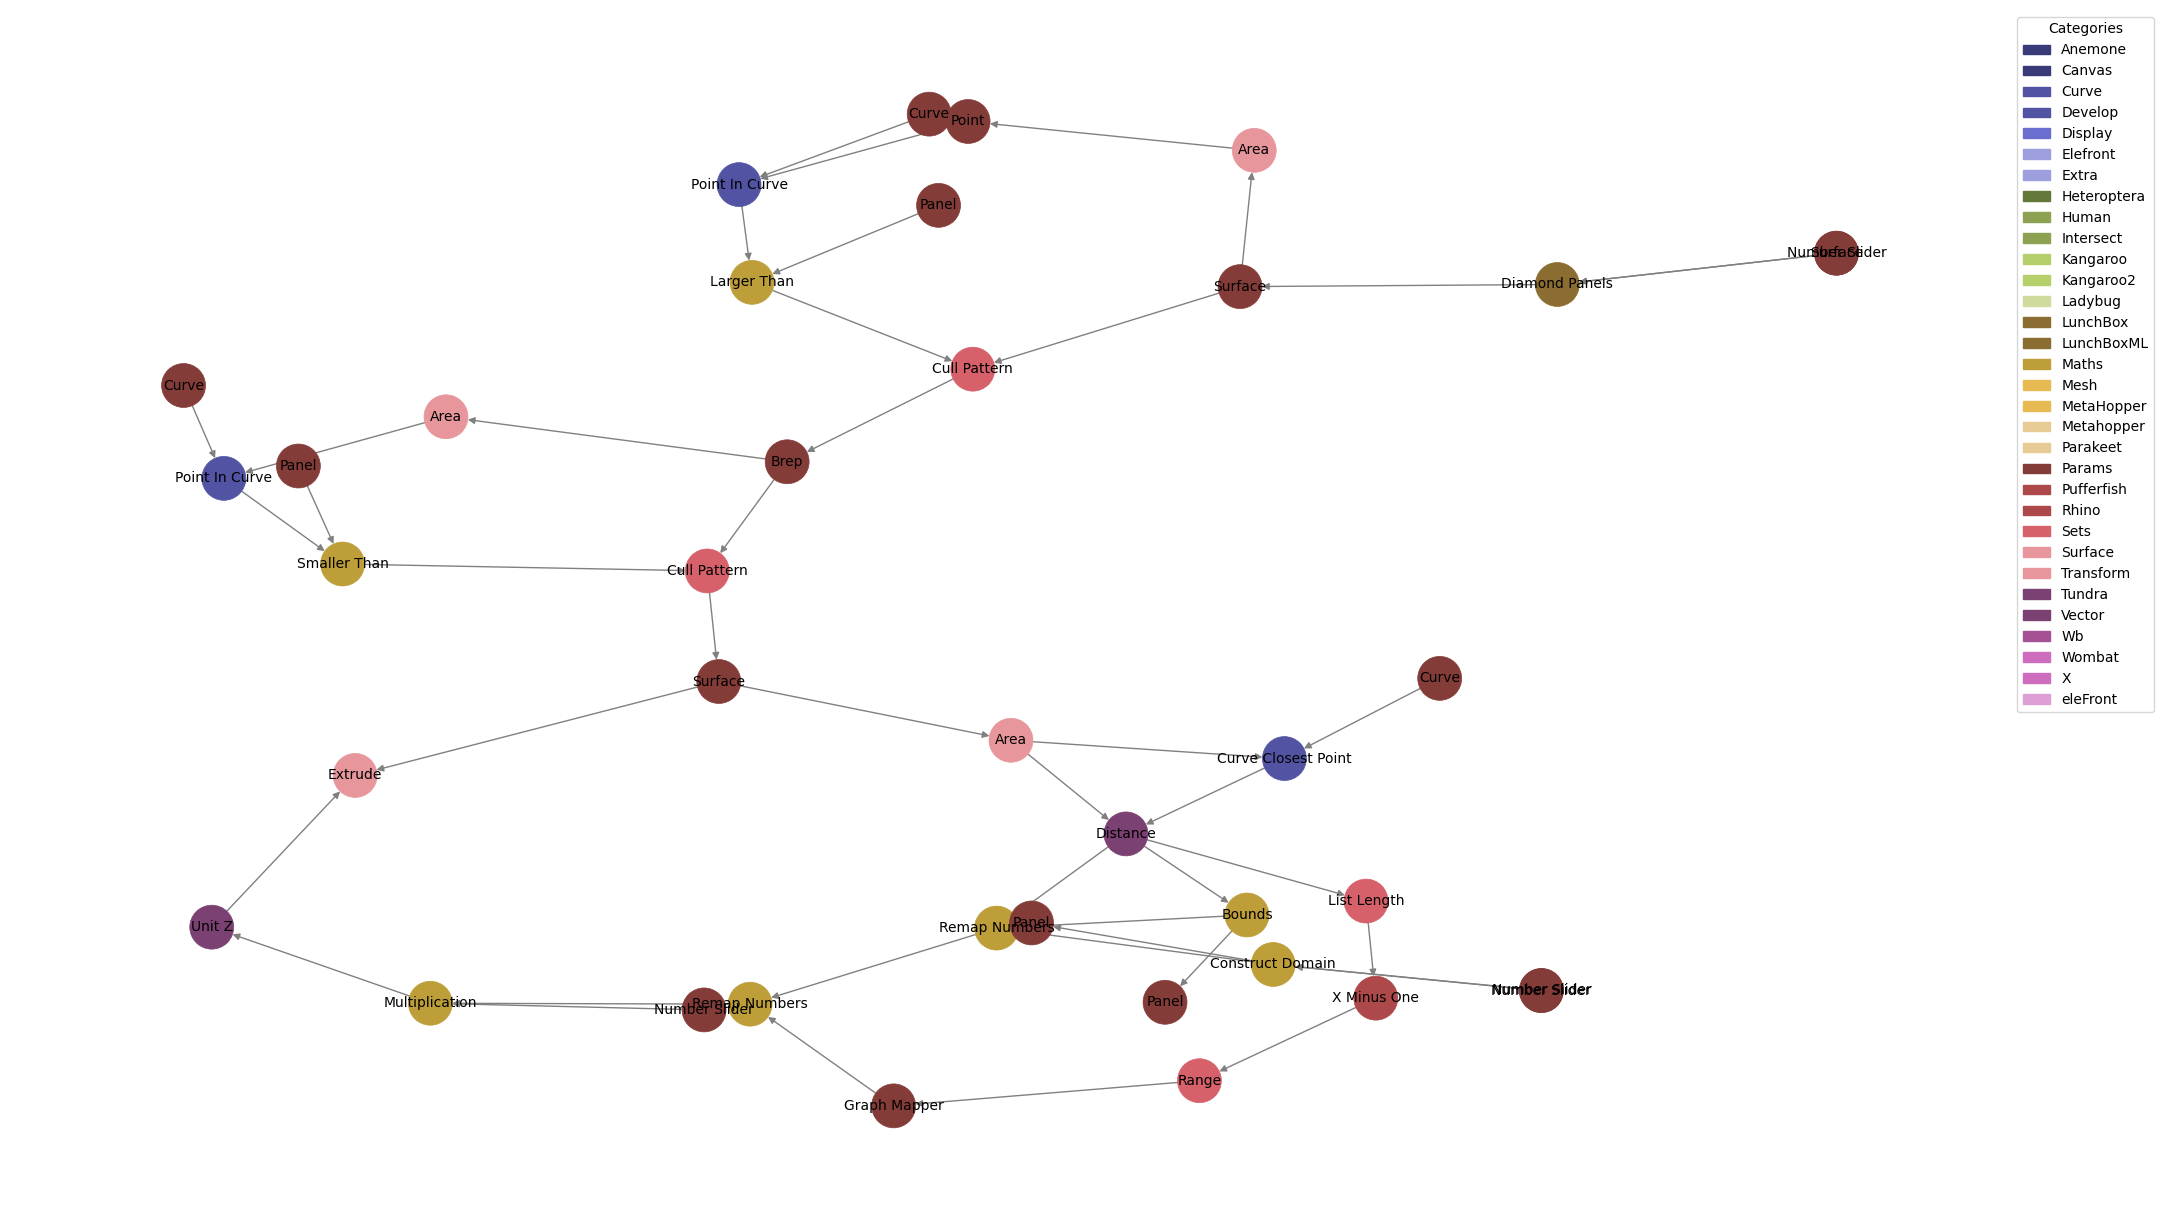

In [11]:
def process_gh_files(path: Union[str, Path]):
    path = Path(path)  # Ensure the path is a Path object

    if path.is_dir():
        # Process each .gh file in the directory
        for file_path in path.glob('*.gh'):
            process_single_file(file_path)
    elif path.is_file() and path.suffix == '.gh':
        # Process a single .gh file
        process_single_file(path)
    else:
        print(f"The path provided is not a .gh file or a directory containing .gh files: {path}")

def process_single_file(file_path: Path):
    print(f"Processing file: {file_path.name}")
    doc = GHProcessor.get_ghdoc(str(file_path))
    canvas = Canvas("canvas", doc, env)
    gh_graph = GHGraph(canvas)
    gh_graph.show_graph()
    gh_graph.save_graph(file_path.with_suffix('.graphml'))


process_gh_files(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\unzips_gh\79B park update 1.gh")